[Reference](https://towardsdatascience.com/deep-walk-the-overlooked-lovechild-of-nlp-and-graph-data-structures-657793831800)

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/')
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks


In [ ]:
import pandas as pd

In [ ]:
skill_data = pd.read_csv("Technology Skills.csv")

In [ ]:
skill_data.head()

,O*NET-SOC Code,Title,Example,Commodity Code,Commodity Title,Hot Technology
0,11-1011.00,Chief Executives,Adobe Systems Adobe Acrobat,43232202,Document management software,Y
1,11-1011.00,Chief Executives,AdSense Tracker,43232306,Data base user interface and query software,N
2,11-1011.00,Chief Executives,Atlassian JIRA,43232201,Content workflow software,Y
3,11-1011.00,Chief Executives,Blackbaud The Raiser's Edge,43232303,Customer relationship management CRM software,N
4,11-1011.00,Chief Executives,ComputerEase Construction Accounting,43231601,Accounting software,N


In [ ]:
import networkx as nx
edges = skill_data[['Title','Example']].values.tolist()
net = nx.from_edgelist(edges)

In [ ]:
def random_walk(graph,seed,rounds=20):
  import random
  movements = [seed]
  for round in range(rounds):
    node_choices = [node for node in graph.neighbors(seed)]
    seed = random.choice(node_choices)
    movements.append(seed)
  return movements

random_walk(net,'Python')

['Python',
 'Financial Quantitative Analysts',
 'SAS',
 'Information Security Analysts',
 'Virus scanning software',
 'Computer Systems Analysts',
 'Adobe Systems Adobe Photoshop',
 'Transportation Planners',
 'Iteris Turbo Architecture',
 'Transportation Planners',
 'IBM SPSS Statistics',
 'Computer and Information Research Scientists',
 'Oracle Solaris',
 'Sales Engineers',
 'Adobe Systems Adobe Flash',
 'Management Analysts',
 'Microsoft Visio',
 'Desktop Publishers',
 'GNU Image Manipulation Program GIMP',
 'Desktop Publishers',
 'OpenOffice.org']

In [ ]:
walks = []
vertices = [n for n in net.nodes]
for v in vertices:
  walks.append(random_walk(graph=net,seed=v))

In [ ]:
from gensim.models.word2vec import Word2Vec
embeddings = Word2Vec(walks,size=10,window=5)

In [ ]:
embeddings.most_similar('C++')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('The MathWorks MATLAB', 0.982986330986023),
 ('Python', 0.9811452627182007),
 ('Biostatisticians', 0.9643651247024536),
 ('National Instruments LabVIEW', 0.9610365629196167),
 ('Formula translation/translator FORTRAN', 0.9603381752967834),
 ('Accelrys Pipeline Pilot', 0.9599730968475342),
 ('Electronics Engineers, Except Computer', 0.9551345109939575),
 ('C', 0.9548431038856506),
 ('UNIX', 0.9512606859207153),
 ('Minitab', 0.9508448839187622)]

In [ ]:
embeddings.save("graph2vec2.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
array_dict = {node:embeddings[node] for node in net.nodes if node in embeddings}
embedded_nodes = [node for node in net.nodes if node in array_dict]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
import numpy as np
arrays = np.array([array_dict[node] for node in embedded_nodes])

In [ ]:
skills = [skill for skill in skill_data['Example'].unique()]
jobs = [job for job in skill_data['Title'].unique()]
skill_idx = [idx for idx,elem in enumerate(embedded_nodes) if elem in skills]
job_idx = [idx for idx,elem in enumerate(embedded_nodes) if elem in jobs]

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
p_comps = pca.fit_transform(arrays)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlim,ylim

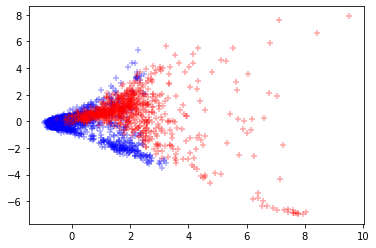

In [ ]:
plt.scatter(
    # Jobs are red, skills are blue
    x=p_comps[:,0],y=p_comps[:,1],color=['b' if idx in skill_idx else 'r' for idx in range(len(arrays))],
    marker='+',
    alpha = 0.35,
    )

In [ ]:
skill_data = pd.read_csv('Technology Skills.csv')
skill_data.head()

x = pd.get_dummies(skill_data.set_index('Title')['Example'])

x = x.groupby(lambda var:var, axis=0).sum()

cols = x.columns.to_list()
rows = x.transpose().columns.to_list()

y = x.to_numpy()

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

job_skill_tensor = torch.FloatTensor(y)

In [ ]:
import random
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_jobs=len(rows), n_skills=len(cols), n_factors=10):
        super().__init__()
        
        self.job_latent = nn.Parameter(torch.rand(n_jobs,n_factors))
        self.skill_latent = nn.Parameter(torch.rand(n_factors, n_skills))
    def forward(self):
        return torch.mm(self.job_latent,self.skill_latent)

In [ ]:
model = MatrixFactorization()
loss_fn = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
losses = []
epochs = 1000
for epoch in range(epochs):
    loss = 0
    
    prediction = model.forward()
    loss += loss_fn(prediction, job_skill_tensor)
    losses.append(loss)

    # Reset the gradients to 0
    optimizer.zero_grad()

    # backpropagate
    loss.backward()

    # update weights
    optimizer.step()
    if epoch % 50 == 0:
        print(loss)

tensor(6.6843, grad_fn=<AddBackward0>)
tensor(0.2142, grad_fn=<AddBackward0>)
tensor(0.0769, grad_fn=<AddBackward0>)
tensor(0.0440, grad_fn=<AddBackward0>)
tensor(0.0284, grad_fn=<AddBackward0>)
tensor(0.0198, grad_fn=<AddBackward0>)
tensor(0.0146, grad_fn=<AddBackward0>)
tensor(0.0113, grad_fn=<AddBackward0>)
tensor(0.0091, grad_fn=<AddBackward0>)
tensor(0.0076, grad_fn=<AddBackward0>)
tensor(0.0065, grad_fn=<AddBackward0>)
tensor(0.0057, grad_fn=<AddBackward0>)
tensor(0.0051, grad_fn=<AddBackward0>)
tensor(0.0047, grad_fn=<AddBackward0>)
tensor(0.0044, grad_fn=<AddBackward0>)
tensor(0.0041, grad_fn=<AddBackward0>)
tensor(0.0039, grad_fn=<AddBackward0>)
tensor(0.0037, grad_fn=<AddBackward0>)
tensor(0.0035, grad_fn=<AddBackward0>)
tensor(0.0034, grad_fn=<AddBackward0>)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
job_features = np.array(model.job_latent.detach())
skill_features = np.array(model.skill_latent.detach())
job_skill_stacked = np.concatenate((job_features,skill_features.transpose()))
job_skill_sim = cosine_similarity(job_skill_stacked)

In [ ]:
import operator
entities = []
entities.extend(rows + cols)

In [ ]:
def get_similar(node,sim_threshold=None,count_threshold=None,category=None):
  idx = entities.index(node)
  sim_scores = job_skill_sim[idx]
  retrieved = [(elem,score) for elem,score in zip(entities,sim_scores)]

  if category == 'jobs':
    retrieved = [tup for idx,tup in enumerate(retrieved) if idx < len(rows)]
  elif category == 'skills':
    retrieved = [tup for idx,tup in enumerate(retrieved) if idx > len(rows)]
  else:
    pass
  
  
  if sim_threshold:
    retrieved = [(elem,score) for elem,score in retrieved if score > sim_threshold]
  
  retrieved = sorted(retrieved,key=operator.itemgetter(1),reverse=True)

  if count_threshold:
    retrieved = [tup for idx,tup in enumerate(retrieved) if idx < count_threshold]  
  
  return retrieved

In [ ]:
get_similar('Python',category='jobs',sim_threshold=0.8,count_threshold=25)

[('Business Intelligence Analysts', 0.9041251),
 ('Computer Network Architects', 0.90234613),
 ('Geographic Information Systems Technicians', 0.89820015),
 ('Software Quality Assurance Engineers and Testers', 0.89739233),
 ('Bus and Truck Mechanics and Diesel Engine Specialists', 0.8867907),
 ('Data Warehousing Specialists', 0.8731143),
 ('Helpers--Production Workers', 0.86763245),
 ('Computer and Information Research Scientists', 0.8654171),
 ('Investment Underwriters', 0.86404276),
 ('Human Resources Specialists', 0.8530033),
 ('Buyers and Purchasing Agents, Farm Products', 0.84368175),
 ('Zoologists and Wildlife Biologists', 0.83144945),
 ('Software Developers, Systems Software', 0.8287494),
 ('Database Administrators', 0.8252903),
 ('Word Processors and Typists', 0.82264125),
 ('Computer Science Teachers, Postsecondary', 0.80951345),
 ('Mechanical Engineers', 0.8093185),
 ('Intelligence Analysts', 0.80497897)]

In [ ]:
# # Save latent feature similarity values in a pickled file!

# import pickle
# with open('cos_sim_pickle.pkl', 'wb') as f:
#   pickle.dump(job_skill_sim, f)

# with open('model.pkl', 'wb') as f:
#   pickle.dump(model, f)  

# with open('latent_features.pkl', 'wb') as f:
#   pickle.dump(job_skill_stacked,f)    

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
p_comps = pca.fit_transform(job_skill_stacked)

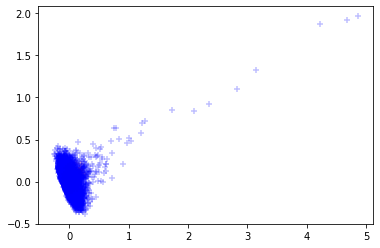

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlim,ylim

plt.scatter(
    x=p_comps[:,0],y=p_comps[:,1],color=['r' if idx < len(rows) else 'b' for idx in range(job_skill_stacked.shape[0])],
    marker='+',
    alpha = 0.25,
    )